Per questo notebook, che ha lo scopo di fornire una panoramica su alcuni strumenti legati all'analisi di reti e di fenomeni di diffusione dell'informazione su di esse, utilizzeremo un piccolo dataset famoso nella Network Science: [Zachary's Karate Club](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm).  
La costruzione di questo dataset è legato a una storia interessante e rappresenta uno delle prime applicazioni degli algoritmi di Community Detection, lascio quindi ai più curiosi un riferimento per [approfondire](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

# Introduzione

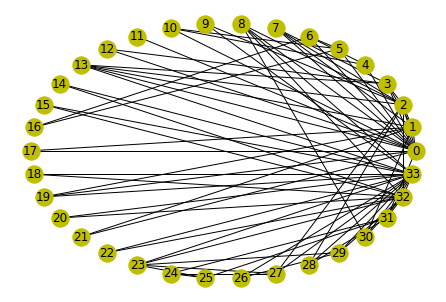

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.karate_club_graph()
nx.draw_circular(G, with_labels=True,node_color='y')
plt.show()

I nodi possono avere informazione (attributi)

In [2]:
G.nodes[0]

{'club': 'Mr. Hi'}

Posso aggiungere attributi, modificarne i valori, ...

In [3]:
G.nodes[0]['status'] = 'infected'

E colorare in base ad essi la rete

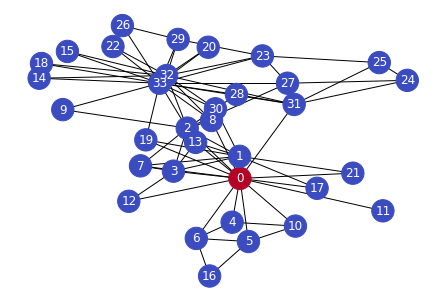

In [4]:
values = [1 if e=='infected' else 0. for e in \
          [G.nodes[i].get('status','susceptible') for i in range(0,len(G.nodes))]]

nx.draw(G, cmap=plt.cm.coolwarm, node_color=values, with_labels=True, font_color='white',node_size=500)
plt.show()

In [5]:
del(G.nodes[0]['status'])

Visualizziamo con una mappa di calore un indice di centralità della rete

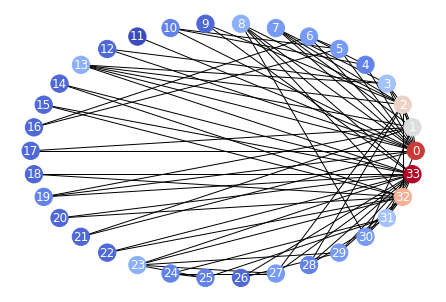

In [6]:
deg_centrality_values = list(nx.degree_centrality(G).values())

nx.draw_circular(G, with_labels=True, node_color=deg_centrality_values, cmap=plt.cm.coolwarm,font_color='white')
plt.show()

Una misura dell'intera rete che rende conto dei legami tra nodi simili sugli attributi è l'[assortatività](http://networksciencebook.com/chapter/7#assortativity).

In [7]:
assortativity = nx.attribute_assortativity_coefficient(G,'club')
print("L'assortatività sul club del Karate Club è {}".format(assortativity))

L'assortatività sul club del Karate Club è 0.717530864197531


# Spatial Spreading

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

#### Cos'è un diagramma di Voronoi?
Nel caso più semplice e comune, quello del piano, dato un insieme finito di punti S, il diagramma di Voronoi per S è la partizione del piano che associa una regione V(p) ad ogni punto p ∈ S in modo tale che tutti i punti all'interno del perimetro di V(p) siano più vicini a p che a ogni altro punto in S. 

In [9]:
def visualize_voronoi_diagram(points,axes):
    vor = Voronoi(points)
    voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1,ax=axes)

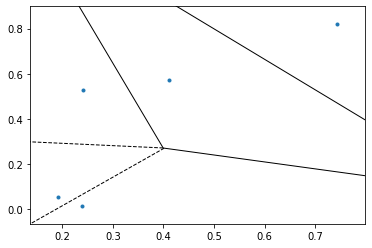

In [10]:
points = np.random.uniform(size=[5, 2])
visualize_voronoi_diagram(points,plt.axes())

#### Visualize Spatial Spreading

- Generiamo uniformemente a caso delle torrette telefoniche in uno spazio a due dimensioni.
- Generiamo estrando da una distribuzione uniforme il numero di cellulari infetti in una cella
- Costruiamo la tesselazione Voronoi
- Normalizziamo i valori degli infetti e stampiamo il diagramma di Voronoi colorandolo con una mappa di calore

In [11]:
def visualize_spatial_spreading(points,values,axes):
    # generate Voronoi tessellation
    vor = Voronoi(points)
    
    # find min/max values for normalization
    minima = min(values)
    maxima = max(values)
    
    # normalize chosen colormap
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
    
    # plot Voronoi diagram, and fill finite regions with color mapped from values
    voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1,ax=axes)
    for r in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            axes.fill(*zip(*polygon), color=mapper.to_rgba(values[r]))

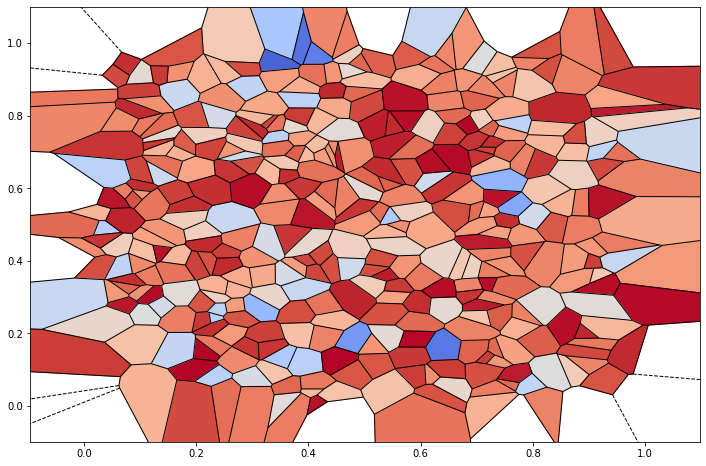

In [12]:
# generate data points (towers) /infected values
numtower = 400
dimension = 2

celltowers = np.random.uniform(size=[numtower, dimension])
infected_in_cell = np.random.power(5.,size=numtower) # P(X=a) ax^(a-1) ; a = .5

# visualize
plt.figure(figsize=(12,8))
ax = plt.axes()
visualize_spatial_spreading(celltowers,infected_in_cell,ax)
plt.show()

In [13]:
def scale(values):
    median = np.median(values)
    iqr = np.quantile(values,0.75) - np.quantile(values,0.25)
    return list(map(lambda x: (x-median)/iqr,values))

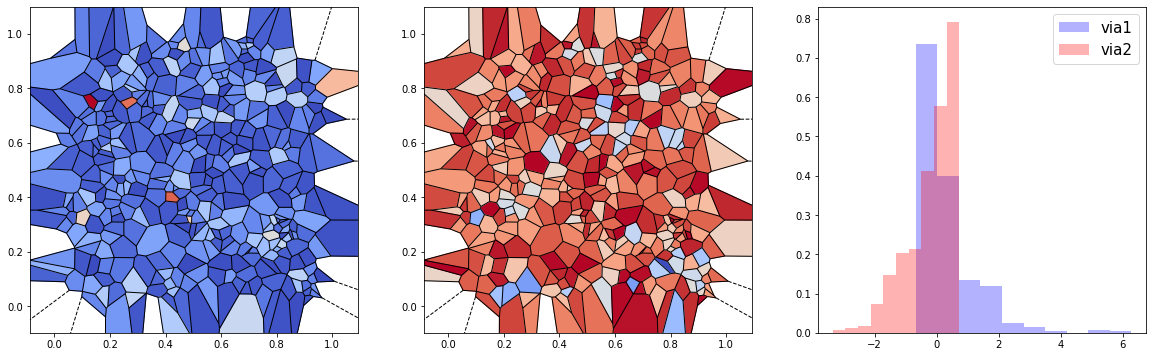

In [14]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(131) #rows, columns, index
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

celltowers = np.random.uniform(size=[numtower, dimension])
infected_in_cell_via1 = np.random.exponential(5.,size=numtower) #5. = \beta = 1 / \lambda
infected_in_cell_via2 = np.random.power(5.,size=numtower) # P(X=a) ax^(a-1) ; a = .5

visualize_spatial_spreading(celltowers,infected_in_cell_via1,ax1)
visualize_spatial_spreading(celltowers,infected_in_cell_via2,ax2)

ax3.hist(scale(infected_in_cell_via1), density=True, alpha=0.3,color='blue',label='via1')
ax3.hist(scale(infected_in_cell_via2), density=True, alpha=0.3,color='red',label='via2')
ax3.legend(prop={'size': 15})

plt.show()

# Epidemics

Per fare una piccola simulazione del diffondersi di un'epidemia utilizzeremo la libreria [NDLib](https://ndlib.readthedocs.io/en/latest/) sul dataset dei personaggi di [Game of Thrones](https://www.kaggle.com/mmmarchetti/game-of-thrones-dataset)

In [15]:
!pip install ndlib

In [16]:
import ndlib
import ndlib.models.epidemics as ep
import json
import pandas as pd

Costruiamo il grafo

In [17]:
g = nx.erdos_renyi_graph(1000, 0.1)

In [18]:
#Create the epidemic model
model = ep.SISModel(g)

#Display model parameters and statuses
print(json.dumps(model.parameters, indent=2))
print()
print('Statuses: ',model.available_statuses)

{
  "model": {
    "beta": {
      "descr": "Infection rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "lambda": {
      "descr": "Recovery rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "tp_rate": {
      "descr": "Whether if the infection rate depends on the number of infected neighbors",
      "range": [
        0,
        1
      ],
      "optional": true,
      "default": 1
    }
  },
  "nodes": {},
  "edges": {}
}

Statuses:  {'Susceptible': 0, 'Infected': 1}


In [19]:
import ndlib.models.ModelConfig as mc

cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) # infection rate
cfg.add_model_parameter('lambda', 0.01) # recovery rate
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

### Simulazione
I modelli di ``NDlib`` diffondo i fenomeni come processi **discrete-time**, **agent-based**: durante ogni iterazione tutti i nodi sono valutati e i loro stati aggiornati in accordo alle regole del modello.

In [20]:
iterations = model.iteration_bunch(200, node_status=True) #display status per node per iteration
iterations[-1] #0: Susceptible, 1: Infected

100%|██████████| 200/200 [00:02<00:00, 74.75it/s] 


{'iteration': 199,
 'status': {115: 1,
  134: 0,
  136: 1,
  208: 1,
  236: 1,
  271: 1,
  362: 1,
  445: 0,
  470: 1,
  517: 1,
  618: 0,
  747: 0,
  845: 0,
  862: 0,
  919: 1,
  920: 1},
 'node_count': {0: 99, 1: 901},
 'status_delta': {0: -4, 1: 4}}

Guardiamo un informazione slegata dalle singole iterazioni

In [21]:
trends = model.build_trends(iterations)
trends #0: Susceptible, 1: Infected

[{'trends': {'node_count': {0: [990,
     989,
     987,
     986,
     983,
     983,
     981,
     981,
     979,
     977,
     977,
     976,
     971,
     970,
     967,
     966,
     961,
     961,
     951,
     943,
     934,
     930,
     926,
     923,
     916,
     907,
     904,
     898,
     894,
     890,
     881,
     868,
     854,
     846,
     833,
     824,
     813,
     792,
     778,
     765,
     741,
     728,
     706,
     692,
     676,
     653,
     634,
     617,
     590,
     568,
     547,
     527,
     513,
     489,
     466,
     440,
     432,
     412,
     404,
     386,
     364,
     345,
     328,
     311,
     298,
     286,
     273,
     269,
     260,
     243,
     224,
     220,
     212,
     205,
     195,
     183,
     169,
     165,
     166,
     171,
     167,
     160,
     165,
     164,
     155,
     150,
     144,
     143,
     146,
     143,
     137,
     125,
     119,
     114,
     104,
     113,
     114,
   

Ci viene in aiuto ancora una volta la visualizzazione

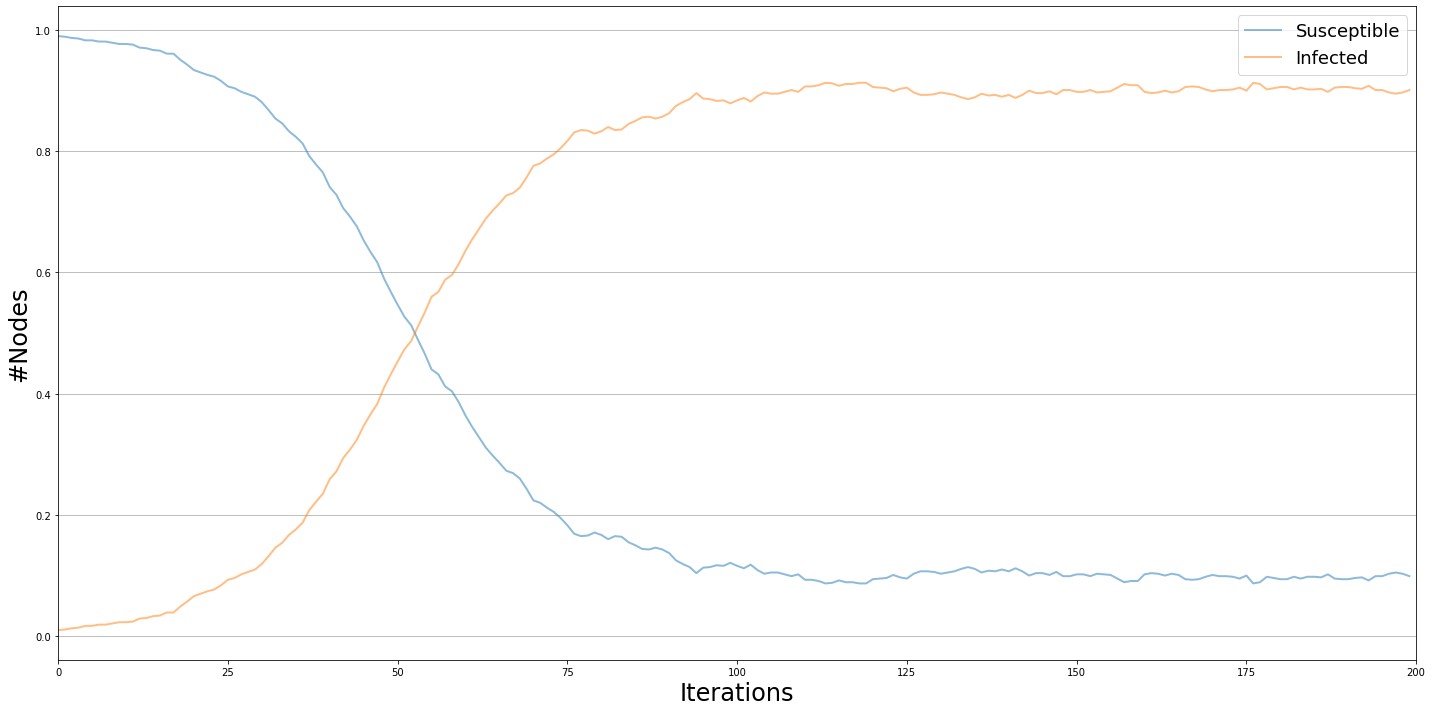

In [22]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model, trends)
viz.plot()

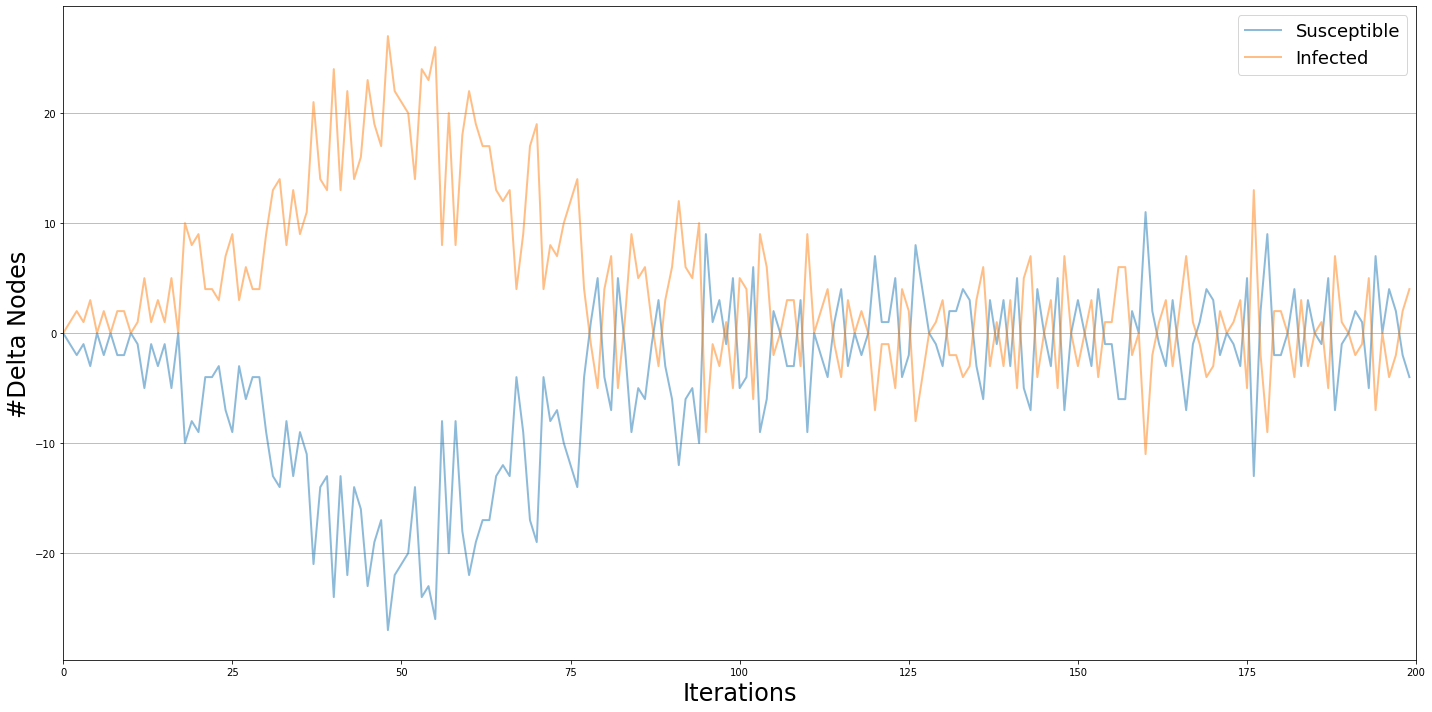

In [23]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence(model, trends)
viz.plot()